In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import time
%matplotlib inline

os.chdir('..\..\..\..')

from input_configuration import base_year

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M"))

Summary run: Tue, 25 May 2021 16:10


In [3]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

# Workers by County

In [4]:
df_wfh = pd.read_csv(os.path.join(working_dir,'wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(working_dir,'survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(working_dir,'pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers = df_tot.sum()['psexpfac']

df_tot_survey = pd.read_csv(os.path.join(working_dir,'survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers_survey = df_tot_survey.sum()['psexpfac']

df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = (df['WFH Workers']/df['Total Workers']).apply(format_percent)
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,"57,312","764,156",7.5%
Kitsap,"9,322","182,852",5.1%
Pierce,"27,571","462,031",6.0%
Snohomish,"23,105","469,669",4.9%
Region,"117,310","1,878,708",6.2%


# Tour Rate for Work-at-Home Workers

In [5]:
df_tours = pd.read_csv(os.path.join(working_dir,'work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(working_dir,'survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,tours_model,tour_rate_model,tours_survey,tour_rate_survey
0,Escort,"44,008",0.38,23855,0.20
1,Meal,"5,781",0.05,13883,0.12
2,Personal Business,"29,728",0.25,37346,0.32
3,School,"2,712",0.02,687,0.01
4,Shop,"37,025",0.32,51688,0.44
5,Social,"36,616",0.31,76994,0.66
6,Work,"12,842",0.11,25335,0.22


### Tour Rates for Workers that do NOT WF

In [6]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
# df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"209,094",0.11,"174,143",0.09
1,Meal,"344,372",0.18,"239,952",0.13
2,Personal Business,"174,949",0.09,"269,849",0.14
3,School,"25,770",0.01,"15,975",0.01
4,Shop,"234,196",0.12,"249,110",0.13
5,Social,"483,218",0.26,"454,542",0.24
6,Work,"1,642,463",0.87,"1,903,086",1.02


### Tour Rates for Non-Workers

In [7]:
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"467,648",0.25,"430,404",0.23
1,Meal,"120,618",0.06,"166,557",0.09
2,Personal Business,"547,657",0.29,"605,619",0.32
3,School,"672,150",0.36,"702,028",0.38
4,Shop,"517,038",0.28,"492,265",0.26
5,Social,"757,930",0.41,"742,332",0.40
6,Work,"54,106",0.03,"131,467",0.07


# Commute Tour Distance
All Workers

In [8]:
df = pd.read_csv(os.path.join(working_dir,'tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [9]:
df_survey = pd.read_csv(os.path.join(working_dir,'survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [10]:
if len(_df_survey) > 0:
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
    print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))
else:
    print(str((_df['toexpfac']*_df['tautodist_bin']).sum()*1.0/_df['toexpfac'].sum()))


model: 10.503332490913406
survey: 10.622522148132719


In [11]:
# Work trip distance to not usual workplace for non-WFH workers


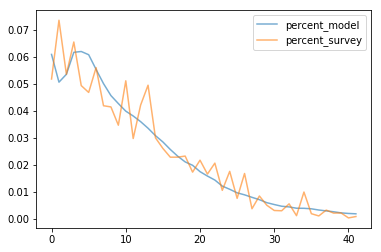

In [12]:
if len(_df_survey) > 0:
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6)
else:
    _df[['percent']].plot(alpha=0.6)

# Average Trip Distance
Workers that work DO NOT work from home

In [13]:
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']
_df_non_wfh

Avg. distance to Usual Workplace: 8.589207518231202
Avg. distance to Other Workplace: 4.654420966437837
----------------------------------------


,Purpose,Workers at Non-Home Location
0,None/Home,5.3803
1,Work,7.8264
2,School,2.8731
3,Escort,5.1958
4,Personal Business,4.4654
5,Shop,3.7045
6,Meal,2.7476
7,Social,3.8512
8,Change Mode Inserted Purpose,8.5351


Only workers that work **from home**

In [14]:
# WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()

_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']
_df_wfh

Avg. distance to Other Workplace: 4.284112259276656
----------------------------------


,Purpose,WFH Workers
0,None/Home,2.5779
1,Work,4.2835
2,School,4.8336
3,Escort,2.5069
4,Personal Business,1.9670
5,Shop,2.0228
6,Meal,1.8308
7,Social,2.0072
8,Change Mode Inserted Purpose,5.3759


In [15]:
# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']
_df_non_worker

,Purpose,Non-Workers
0,None/Home,5.3803
1,Work,7.8264
2,School,2.8731
3,Escort,5.1958
4,Personal Business,4.4654
5,Shop,3.7045
6,Meal,2.7476
7,Social,3.8512
8,Change Mode Inserted Purpose,8.5351


Average Trip Distance by Purpose and Worker/Person Type

In [16]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [17]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,None/Home,5.3803,2.5779,5.3803
1,Work,7.8264,4.2835,7.8264
2,School,2.8731,4.8336,2.8731
3,Escort,5.1958,2.5069,5.1958
4,Personal Business,4.4654,1.9670,4.4654
5,Shop,3.7045,2.0228,3.7045
6,Meal,2.7476,1.8308,2.7476
7,Social,3.8512,2.0072,3.8512
8,Change Mode Inserted Purpose,8.5351,5.3759,8.5351


# VMT

Workers that Work from Home

In [18]:
df = pd.read_csv(os.path.join(working_dir,'vmt_wfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_wfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_wfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_wfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,224,0.00,22087,0.19
Escort,126108,1.08,102084,0.87
Meal,21560,0.18,18337,0.16
None/Home,352250,3.00,275291,2.35
Personal Business,114490,0.98,32471,0.28
School,4906,0.04,442,0.00
Shop,137211,1.17,217770,1.86
Social,79579,0.68,125873,1.07
Work,13297,0.11,28235,0.24


Workers that do NOT Work from Home

In [19]:
df = pd.read_csv(os.path.join(working_dir,'vmt_nonwfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_nonwfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_nonwfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_nonwfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,269990,0.14,140005,0.08
Escort,2692673,1.43,2680996,1.44
Meal,1250369,0.67,1532333,0.82
None/Home,16367177,8.71,13921007,7.46
Personal Business,2000473,1.06,2260473,1.21
School,199238,0.11,55732,0.03
Shop,2321052,1.24,3274347,1.76
Social,2411541,1.28,2734787,1.47
Work,16766082,8.92,16329306,8.76
